In [3]:
import pandas as pd;
import pingouin as pg;
import seaborn as sns;
import scipy.stats as stats;
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as scp
import statsmodels as st

# Lectura de los datos

In [4]:
cnn_no_ll24_cv_10_3 = pd.read_csv('Resultados/lag24/NO/CNN/CNN-NO-LL24-Crosvalidacion-media24steps.csv',
                                 index_col=0)
gru_no_ll24_cv_10_3 = pd.read_csv('Resultados/lag24/NO/GRU/GRU-NO-LL24-Crosvalidacion-media24steps.csv',
                                 index_col=0)
lstm_no_ll24_cv_10_3  = pd.read_csv('Resultados/lag24/NO/LSTM/LSTM-NO-LL24-Crosvalidacion-media24steps.csv',
                                 index_col=0)
rsme_no_ll24 = pd.DataFrame({"gru":gru_no_ll24_cv_10_3['RMSE'],
                             "cnn":cnn_no_ll24_cv_10_3['RMSE'],
                             "lstm":lstm_no_ll24_cv_10_3['RMSE']})
mae_no_ll24 = pd.DataFrame({"gru":gru_no_ll24_cv_10_3['MAE'],
                             "cnn":cnn_no_ll24_cv_10_3['MAE'],
                             "lstm":lstm_no_ll24_cv_10_3['MAE']})
cc_no_ll24 = pd.DataFrame({"gru":gru_no_ll24_cv_10_3['CC'],
                             "cnn":cnn_no_ll24_cv_10_3['CC'],
                             "lstm":lstm_no_ll24_cv_10_3['CC']})


## RSME

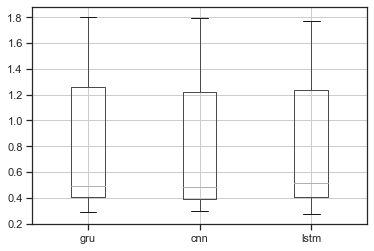

In [3]:
rsme_no_ll24.boxplot()

## Test estadísticos

Primero hay que comprobar si las muestras proceden de una distribución normal. Para ello, aplicamos el test de Shapiro-Wilks, para determinar si las muestras proceden de una distribución normal

In [4]:
rsme_no_ll24.apply(stats.shapiro)

gru     (0.8127288818359375, 0.00011284616630291566)
cnn       (0.808948278427124, 9.585390944266692e-05)
lstm    (0.8350979089736938, 0.00030700559727847576)
dtype: object

Como se puede apreciar, todos los p-values (segundos valores en cada valor devuelto) es menor que 0.05 con lo que con una confinaza del 95% podemos rechazar la hipótesis de que las muestras proceden de una distribución normal. Esto también se puede ver por las gráficas de densidad, en las que se ve claramente que no siguen una distribución normal. 

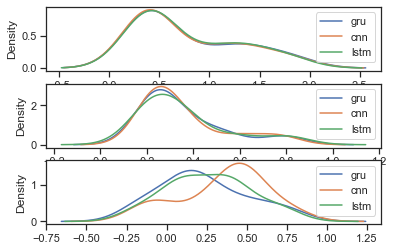

In [5]:
dataSets = (rsme_no_ll24,mae_no_ll24,cc_no_ll24)
fig, axes = plt.subplots(3, 1)
for  df,i in zip(dataSets,range(3)):
     df.plot(kind='density', ax=axes[i]);

TODO: descrubir la forma de poner los títulos en cada figura. 

Al no poder aplicar una técnica paramétrica, se procede a comprobar si hay diferencias significativas entre los tres modelos con el test de Friedman. 

In [6]:
stats.friedmanchisquare(rsme_no_ll24.gru,rsme_no_ll24.lstm,rsme_no_ll24.cnn)

FriedmanchisquareResult(statistic=6.199999999999989, pvalue=0.04504920239355807)

Al ser el pvalue menor que 0.05, con un 95% podemos afirmar que existen diferencias significativas, vamos a proceder a localizar donde están esas diferencias significativas aplicando el test post-hoc de Nemenyi.

In [7]:
scp.posthoc_nemenyi_friedman(rsme_no_ll24, melted=False)

,gru,cnn,lstm
gru,-1.000000,0.128475,0.052581
cnn,0.128475,-1.000000,0.900000
lstm,0.052581,0.900000,-1.000000


Haciendo los test por pares para localizar donde están diferencias significativas estas no se encuntran. Esto puede ocurrir al estar el resultado del test de Friedman cerca de límite.

Vamos a intentar una transformación logarítmica de lsos datos para ver si se cumplen los criterios de parametricidad. Empezaremos por comporbar la normalida

In [8]:
np.log(rsme_no_ll24).apply(stats.shapiro)

gru     (0.8686501979827881, 0.0015635015442967415)
cnn     (0.8588370084762573, 0.0009547794470563531)
lstm     (0.8955364227294922, 0.006543213501572609)
dtype: object

Como podemos ver una transformación logarítmica tampoco funciona. Ya sólo nos queda por comprobar una comparación por pares utilizando el test te wilcoxon.

In [9]:
cols = rsme_no_ll24.columns
pvalues = np.array([])
rmse_ranks = pd.DataFrame({"wins":np.zeros(3),
                     "ties":np.zeros(3),
                     "losses":np.zeros(3)})
rmse_ranks.index= cols
rmse_ranks.index= cols
for index1 in range(len(cols)):
    for index2 in range(index1+1,len(cols)):
        T,p = stats.wilcoxon(rsme_no_ll24.iloc[:,index1],rsme_no_ll24.iloc[:,index2])
        test,padjust,a1,a2 = st.stats.multitest.multipletests(p,alpha = 0.05,method = "bonferroni")
        if not test:
            rmse_ranks.iloc[index1,1] =rmse_ranks.iloc[index1,1]+1
            rmse_ranks.iloc[index2,1] = rmse_ranks.iloc[index2,1]+1
        else:
            if rsme_no_ll24.iloc[:,index1].mean() > rsme_no_ll24.iloc[:,index2].mean():
                rmse_ranks.iloc[index1,0] =rmse_ranks.iloc[index1,0]+1
                rmse_ranks.iloc[index2,2] = rmse_ranks.iloc[index2,2]+1
            else:
                rmse_ranks.iloc[index2,0] = rmse_ranks.iloc[index2,0]+1
                rmse_ranks.iloc[index1,1] = rmse_ranks.iloc[index1,2]+1
                
rmse_ranks["diff"] = rmse_ranks.wins-rmse_ranks.losses
rmse_ranks = rmse_ranks.sort_values(by="diff",ascending = False)
rmse_ranks

,wins,ties,losses,diff
gru,1.0,1.0,0.0,1.0
lstm,0.0,2.0,0.0,0.0
cnn,0.0,1.0,1.0,-1.0


# MAE

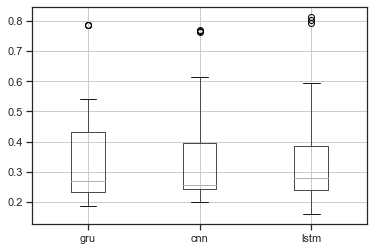

In [10]:
mae_no_ll24.boxplot()

## Tests estadísticos

In [ ]:
mae_no_ll24.boxplot()

Comprobación de la normalidad

In [11]:
mae_no_ll24.apply(stats.shapiro)

gru       (0.7871785163879395, 3.8616872188868e-05)
cnn     (0.7480366230010986, 8.466297913400922e-06)
lstm    (0.8196220397949219, 0.0001526105625089258)
dtype: object

Como podemos apreciar, al 95% de confianza podemos rechazar la hipótesis nula de que las distintas muestras proceden de una distribución normal. También lo podemos comprobar gráficamente. 

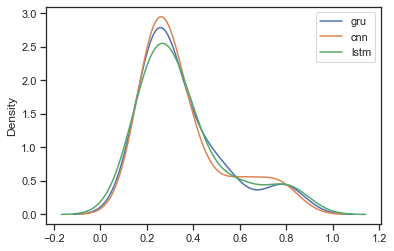

In [12]:
mae_no_ll24.plot(kind='density')

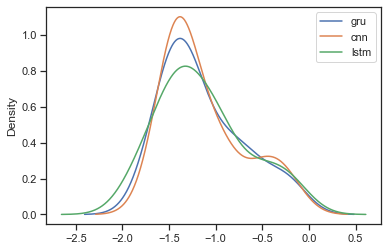

In [13]:
np.log(mae_no_ll24).plot(kind='density')

In [14]:
np.log(mae_no_ll24).apply(stats.shapiro)

gru      (0.8911484479904175, 0.0051367017440497875)
cnn     (0.8308230042457581, 0.00025233172345906496)
lstm       (0.9328707456588745, 0.05855398625135422)
dtype: object

Se puede apreciar que una transformación logarítmica tampoco soluciona el problema de la no normalidad. Prodecdemos entonces a realizar el test de Friedman.

In [15]:
stats.friedmanchisquare(mae_no_ll24.gru,mae_no_ll24.lstm,mae_no_ll24.cnn)

FriedmanchisquareResult(statistic=0.46666666666664014, pvalue=0.7918895663367922)

En este caso y al 95% de confianza podemos indicar que no existen diferencias significativas (pvalue=0.79>0.05). Esto lo tiene que confirmar el test de Nemenyi.

In [16]:
scp.posthoc_nemenyi_friedman(mae_no_ll24, melted=False)

,gru,cnn,lstm
gru,-1.000000,0.848105,0.774254
cnn,0.848105,-1.000000,0.900000
lstm,0.774254,0.900000,-1.000000


Según esto todo serían empates. Pero vamos a comprobarlo con el test de wilcoxon por pares.

In [20]:
cols = mae_no_ll24.columns
pvalues = np.array([])
mae_ranks = pd.DataFrame({"wins":np.zeros(3),
                     "ties":np.zeros(3),
                     "losses":np.zeros(3)})
mae_ranks.index= cols
for index1 in range(len(cols)):
    for index2 in range(index1+1,len(cols)):
        T,p = stats.wilcoxon(mae_no_ll24.iloc[:,index1],mae_no_ll24.iloc[:,index2])
        test,padjust,a1,a2 = st.stats.multitest.multipletests(p,alpha = 0.05,method = "bonferroni")
        if not test:
            mae_ranks.iloc[index1,1] = mae_ranks.iloc[index1,1]+1
            mae_ranks.iloc[index2,1] = mae_ranks.iloc[index2,1]+1
        else:
            if mae_no_ll24.iloc[:,index1].mean() > mae_no_ll24.iloc[:,index2].mean():
                mae_ranks.iloc[index1,0] = mae_ranks.iloc[index1,0]+1
                mae_ranks.iloc[index2,2] = mae_ranks.iloc[index2,2]+1
            else:
                mae_ranks.iloc[index2,0] = mae_ranks.iloc[index2,0]+1
                mae_ranks.iloc[index1,1] = mae_ranks.iloc[index1,2]+1
                
mae_ranks["diff"] = mae_ranks.wins-mae_ranks.losses
mae_ranks = mae_ranks.sort_values(by="diff",ascending = False)
mae_ranks

,wins,ties,losses,diff
gru,0.0,2.0,0.0,0.0
cnn,0.0,2.0,0.0,0.0
lstm,0.0,2.0,0.0,0.0


# CC

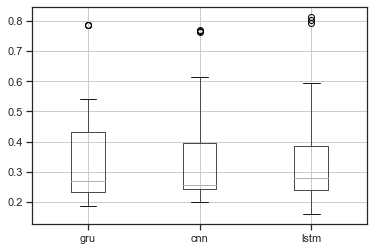

In [21]:
mae_no_ll24.boxplot()

## Test estadísticos paramétricos

comprobación de la normalidad

In [6]:
cc_no_ll24.apply(stats.shapiro)

gru     (0.9473890662193298, 0.14386078715324402)
cnn     (0.9143109917640686, 0.01914365030825138)
lstm    (0.9627966284751892, 0.36443835496902466)
dtype: object

En este caso, al 95% de confianza no podemos rechazar la hipótesis nula de que las muestreas de cada modelo procedan de una distribución normal. La otra condición de parametricidad que hay que comprobar el la esfercidad a través del test de Mauchly.

In [7]:
pg.sphericity(cc_no_ll24)

(True, 0.9756501456698216, 0.6902339958005032, 2, 0.7081374980205799)

Con el 95% de confianza no podemos rechazar la hipótesis nula de que las muestras cumple la condición de esfericidad (pvalue=0.7 > 0.05). Al cumplirse las dos condiciones podemos aplicar el test ANOVA con medidas repetidas para comprobar si hay diferencias significativas en los métodos. 

In [8]:
cc_no_ll24.rm_anova()

,Source,ddof1,ddof2,F,p-unc,np2,eps
0,Within,2,58,16.761015,0.000002,0.366273,0.976229


Como podemos observar, al 95% de confianza, podemos rechazar la hipótesis nula de que no existen diferencias significativas entre los mdelos. Vamos a reslizar un test post-hoc de Tukey para ver dónde están dichas diferencias. 

Primero, para poder utilizar la función debemos modificar el data frame para crear una nueva versión utilizando el método `melted()`.

In [9]:
cc_melted = cc_no_ll24.melt()
cc_melted["subject"] = [i for _ in range(3) for i in range(1, 31)]
cc_melted

,variable,value,subject
0,gru,0.170892,1
1,gru,0.573044,2
2,gru,0.406057,3
3,gru,-0.086384,4
4,gru,0.146501,5
...,...,...,...
85,lstm,0.414315,26
86,lstm,0.074001,27
87,lstm,0.324836,28
88,lstm,0.701757,29


Ahora ya podemos realizar el test de Tukey.

In [10]:
tukey_test = pg.pairwise_tukey(data=cc_melted, dv='value', between='variable')
tukey_test

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,cnn,gru,0.356369,0.231382,0.124987,0.068537,two-sided,1.823634,0.163149,0.464745
1,cnn,lstm,0.356369,0.261304,0.095065,0.068537,two-sided,1.387051,0.348982,0.353484
2,gru,lstm,0.231382,0.261304,-0.029922,0.068537,two-sided,-0.436583,0.893456,-0.111261
